In [60]:
import kagglehub
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image

# Chargement de la data

In [61]:
# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

train_path = os.path.join(path, "seg_train", "seg_train")
test_path = os.path.join(path, "seg_test", "seg_test")
predict_path = os.path.join(path, "seg_pred")

Path to dataset files: /Users/erwan/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


# Chargement des datasets

In [62]:
IMG_SIZE = (150, 150)
BATCH_SIZE = 128
SEED = 42

Pour la chargement du dataset nous utilison la fonction suivant : `image_dataset_from_directory`

Elle permet de directement d'avoir :
- un chargement efficace des images
- des prétraitements intégrés
- et une optimisation avec TensorFlow

Voici une explication des paramètres importants : 

|                 **Paramètre**                	|                           **Description**                          	|
|:--------------------------------------------:	|:------------------------------------------------------------------:	|
| `directory`                                  	| Chemin du dataset.                                                 	|
| `labels="inferred"`                          	| Déduit les labels des noms de sous-dossiers.                       	|
| `label_mode="int"`                           	| Les labels sont encodés comme des entiers.                         	|
| `batch_size=32`                              	| Nombre d’images chargées par batch.                                	|
| `image_size=(150,150)`                       	| Redimensionne les images à cette taille.                           	|
| `validation_split=0.2`                       	| Réserve 20% des images pour la validation.                         	|
| `subset="training"`<br>`subset="validation"` 	| Permet de séparer le dataset.                                      	|
| `shuffle=True`                               	| Mélange les images pour éviter les biais.                          	|
| `seed=42`                                    	| Assure que le split train/val est reproductible en fixant la seed. 	|

## Chargement du dataset de **train / validation**

## train_dateset
Permet d'enseigner au modèle à reconnaître les images, est utilisé durant l'entraînement du modèle (`modele.fit()`) et contient 80% des données d'entraînement.

## val_dataset
Permet de vérifier la performance du modèle pendant l'entraînement, afin de détecter l’overfitting (si la perte val_loss augmente mais train_loss diminue) et d'ajuster les hyperparamètres (nombre de couches, learning rate, data augmentation, etc.). Il contient 20% des données d'entraînement.

In [63]:
train_dataset, val_dataset = keras.utils.image_dataset_from_directory(
    train_path,
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,  # 80% train / 20% validation
    subset="both",
    seed=SEED
)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Using 2806 files for validation.


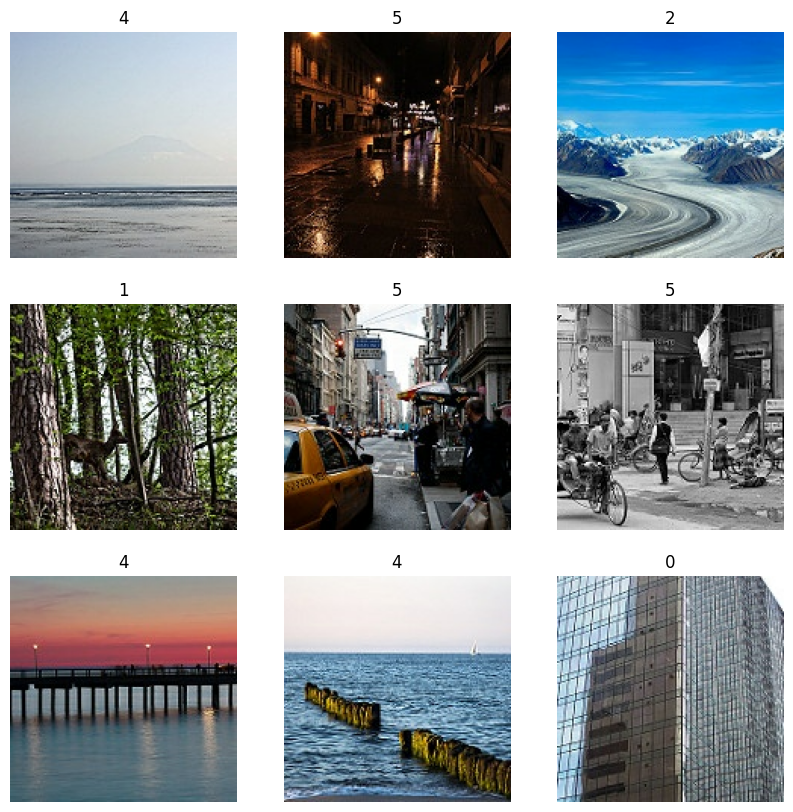

In [64]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Chargement du dataset de **test**


## test_dataset
Permet de mesurer la vraie performance du modèle après l'entraînement, afin de calculer la pprécision et de voir comment le modèle se comporte sur des images qu'il n'a jamais vues. Il contient des images inédites labelisées, on l'utilise avec `model.evaluate(test_dataset)`.

In [65]:
test_dataset = keras.utils.image_dataset_from_directory(
    test_path,
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

Found 3000 files belonging to 6 classes.


## Chargement du dataset de **prédiction**

## predict_dataset
Permet de faire des prédictions sur des images sans labels. , on l'utilise avec `model.predict(predict_dataset)`.

In [66]:
predict_dataset = keras.utils.image_dataset_from_directory(
    predict_path,
    labels=None,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

Found 7301 files.


# Data Augmentation

Data Augmentation (ou augmentation de données) est une technique qui génère des variations artificielles des images d'entraînement. Cela permet d’augmenter la diversité des données sans collecter plus d’images. Elle seulement est appliqué sur le dataset d'entraînement.

|    **Paramètre**    	|                 **Description**                 	|
|:-------------------:	|:-----------------------------------------------:	|
| `RandomFlip`        	| Retourne l’image horizontalement/verticalement. 	|
| `RandomRotation`    	| Fait tourner légèrement l’image.                	|
| `RandomZoom`        	| Simule un zoom avant/arrière.                   	|
| `RandomBrightness`  	| Change la luminosité.                           	|
| `RandomContrast`    	| Modifie le contraste.                           	|
| `RandomTranslation` 	| Déplace légèrement l’image.                     	|

In [67]:
data_augmentation_layers = [
    keras.layers.RandomFlip(mode="horizontal_and_vertical"),
    keras.layers.RandomRotation(factor=0.2, fill_mode="reflect", interpolation="bilinear"),
    keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="reflect", interpolation="bilinear"),
    keras.layers.RandomContrast(factor=0.2),
    keras.layers.RandomBrightness(factor=0.2),
    keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode="reflect", interpolation="bilinear")
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

2025-02-13 23:35:31.076756: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


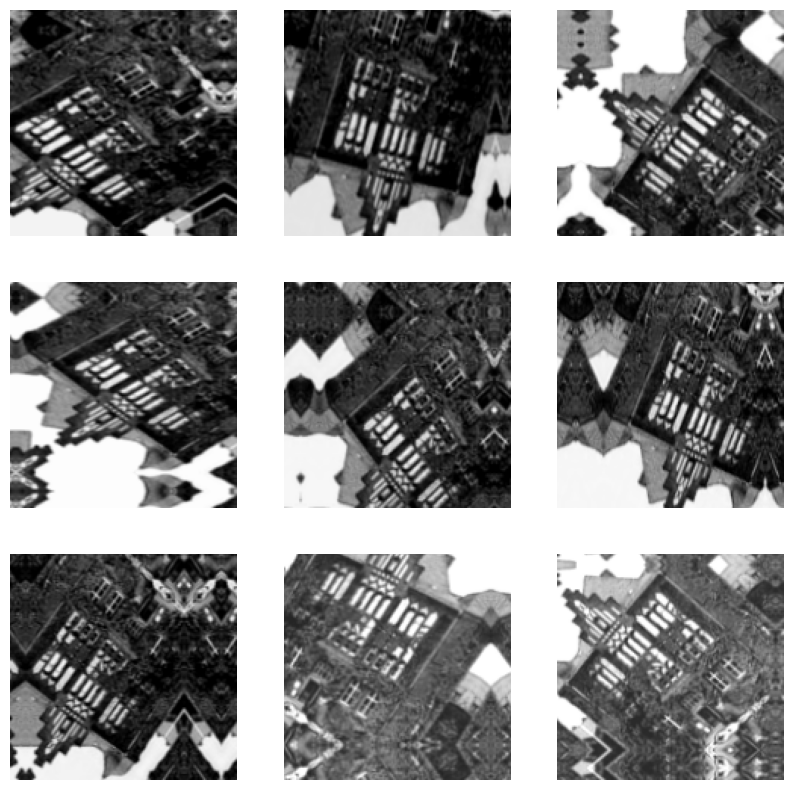

In [68]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

# Application de l'augmentation de donnée sur le dataset

In [69]:
train_dataset = train_dataset.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Création du modèle

Nos images ont déjà une taille standard (150x150). Cependant, les valeurs de leurs canaux RGB se situent dans la plage [0, 255]. Ce n'est pas l'idéal pour un réseau neuronal ; en général, il faut chercher à réduire les valeurs d'entrée. Ici, nous normaliserons les valeurs pour qu'elles se situent dans la plage [0, 1] en utilisant une couche de mise à l'échelle au début de notre modèle avec : `x = keras.layers.Rescaling(1.0 / 255)(inputs)`

In [70]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = keras.layers.Rescaling(1.0 / 255)(inputs)
    x = keras.layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = keras.layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = keras.layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.25)(x)

    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=IMG_SIZE + (3,), num_classes=6)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 150, 150,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 75, 75,    │      3,584 │ rescaling_2[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 75, 75,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 75, 75,    │          0 │ activation_8[0][… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_7  │ (None, 75, 75,    │     34,176 │ activation_9[0][… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 75, 75,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_8  │ (None, 75, 75,    │     68,096 │ activation_10[0]… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 38, 38,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 38, 38,    │     33,024 │ activation_8[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 38, 38,    │          0 │ max_pooling2d_3[… │
│                     │ 256)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 38, 38,    │          0 │ add_3[0][0]       │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_9  │ (None, 38, 38,    │    133,888 │ activation_11[0]… │
│ (SeparableConv2D)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 38,    │      2,048 │ separable_conv2d

 Total params: 2,736,190 (10.44 MB)

 Trainable params: 2,727,902 (10.41 MB)

 Non-trainable params: 8,288 (32.38 KB)

# Entraînement du modèle

Un callback est une fonction qui intervient automatiquement pendant l'entraînement du modèle. Il permet de contrôler et améliorer l’entraînement en temps réel.

Ils sont appelés à différents moments :
- Avant ou après chaque batch (on_batch_end)
- Avant ou après chaque epoch (on_epoch_end)
- Avant ou après l’entraînement complet (on_train_end)


|       **Callback**      	|                                              **Description**                                             	|
|:-----------------------:	|:--------------------------------------------------------------------------------------------------------:	|
| `ModelCheckpoint`       	| Sauvegarde automatiquement le meilleur modèle basé sur `val_accuracy`.                                   	|
| `BackupAndRestore`      	| Permet de reprendre l'entraînement en cas d'arrêt accidentel.                                            	|
| `TerminateOnNaN`        	| Stoppe immédiatement si `loss` devient NaN.                                                              	|
| `EarlyStopping`         	| Arrête l'entraînement si l'amélioration ralentit, évite l'overfitting et réduit le temps d'entraînement. 	|
| `ReduceLROnPlateau`     	| Réduit automatiquement le `learning rate` si `val_loss` stagne.                                          	|
| `LearningRateScheduler` 	| Change dynamiquement le `learning rate` selon une fonction.                                              	|

In [71]:
callbacks = [
    keras.callbacks.ModelCheckpoint('from_scratch_cnn_model.keras', monitor='val_accuracy', save_best_only=True, mode='max'),
    keras.callbacks.BackupAndRestore(backup_dir='./backup'),
    keras.callbacks.TerminateOnNaN(),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
]

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

history = model.fit(
    train_dataset,
    epochs=60,
    callbacks=callbacks,
    validation_data=val_dataset,
)


Epoch 1/60
 2/88 ━━━━━━━━━━━━━━━━━━━━ 10:56 8s/step - accuracy: 0.2090 - loss: 1.8274 

KeyboardInterrupt: 

In [ ]:
def plot_hist(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(history)

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.7093
Test Loss: 1.1856

In [ ]:
def get_random_image_path(folder_path):
    try:
        files = os.listdir(folder_path)
        # Filter the list to get only image files
        images = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]

        if not images:
            print("No images found in the specified folder.")
            print(f"Folder path: {folder_path}")
            return None

        # Choose a random image file
        random_image = random.choice(images)
        random_image_path = os.path.join(folder_path, random_image)
        return random_image_path
      
    except Exception as e:
        print(f"An error occurred while selecting image randomly: {e}")
        return None

In [ ]:
img = Image.open(get_random_image_path(predict_path + "/seg_pred"))
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)

predictions = model.predict(img_array)
predicted_class = tf.argmax(predictions, axis=1).numpy()[0]

class_names = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
predicted_label = class_names[predicted_class]

print(f"🏆 Representation : {predicted_label} with {100 * tf.reduce_max(predictions):.2f}% confidence")

# Modèle via transfer learning avec EfficientNet

In [ ]:
inputs = keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
efficient_net_model = keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False, weights='imagenet', input_tensor=inputs)

# Freeze the pretrained weights
efficient_net_model.trainable = False

# Rebuild top
x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(efficient_net_model.output)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Dropout(0.2, name="top_dropout")(x)
outputs = keras.layers.Dense(6, activation="softmax", name="pred")(x)

# Compile
efficient_net_model = keras.Model(inputs=inputs, outputs=outputs, name="EfficientNet")
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
efficient_net_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
efficient_net_history = efficient_net_model.fit(train_dataset, epochs=10, validation_data=val_dataset)
plot_hist(efficient_net_history)